## Dataset

1. We use the Bank Marketing Dataset from the UCI Machine Learning Repository.
Source: https://archive.ics.uci.edu/ml/datasets/bank+marketing

2. The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. Originally designed for supervised learning, but we will ignore the label initially

Important Decision:

Even though the dataset contains subscribed (whether the client subscribed to a term deposit), we do not use it to train the clustering model.
We may, however, use it later for interpretation only.

    # bank client data:
    1 - age (numeric)
    2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
    3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
    4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
    5 - default: has credit in default? (categorical: 'no','yes','unknown')
    6 - housing: has housing loan? (categorical: 'no','yes','unknown')
    7 - loan: has personal loan? (categorical: 'no','yes','unknown')
    # related with the last contact of the current campaign:
    8 - contact: contact communication type (categorical: 'cellular','telephone')
    9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
    10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
    11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
    # other attributes:
    12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
    13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
    14 - previous: number of contacts performed before this campaign and for this client (numeric)
    15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
    # social and economic context attributes
    16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
    17 - cons.price.idx: consumer price index - monthly indicator (numeric)
    18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
    19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
    20 - nr.employed: number of employees - quarterly indicator (numeric)
    21 - y - has the client subscribed a term deposit? (binary: 'yes','no')

## task 1

### Requirements

The goal of this lab is to **explore the bank dataset, prepare it for clustering, and apply K-Means**.  
Follow these steps carefully and write down your observations.  

### **Exploratory Data Analysis (EDA)** (understanding the dataset and its characteristics)

For each feature, you should:

- Identify **numeric vs categorical features**  
- Check **distributions** of numeric features (min, max, mean, std, skewness)  
- Check **counts of categories** for categorical features  
- Identify **missing or unknown values** and decide how to handle them  
- Look for **correlations** between numeric features  
- Identify **outliers** that may affect clustering  

In [124]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
import warnings

In [125]:
#load the dataset
df = pd.read_csv('bank-full.csv', sep=';')
print(f'Dataset loaded: {df.shape[0]:,} rows, {df.shape[1]} columns')
print(f'\nColumns: {list(df.columns)}')

#see first 5 rows
print("First 5 rows:")
print(df.head())
print("\n")

Dataset loaded: 45,211 rows, 17 columns

Columns: ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']
First 5 rows:
   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome   y  
0  unknown    5   may       261         1     -1         0  unknown  no  
1  unknown    5   may       151         1     -1         0  unknown  no  
2  unknown    5   may        76         1     -1         0  unknown  no  
3  unknown    5   may     

In [126]:
#info
print('Dataset Info:')
df.info()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [127]:
#identify numeric vs categorical features
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
print(f'Numeric features ({len(numeric_features)}): {numeric_features}')
print(f'\nCategorical features ({len(categorical_features)}): {categorical_features}')

Numeric features (7): ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

Categorical features (10): ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']


In [128]:
#check distributions of numeric features (min, max, mean, std, skewness) 
df[numeric_features].describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [129]:
#count categories for categorical features
for col in categorical_features:
    print(f'\n{col}: {df[col].nunique()} categories')
    print(df[col].value_counts().head())
    print('-'*40)


job: 12 categories
job
blue-collar    9732
management     9458
technician     7597
admin.         5171
services       4154
Name: count, dtype: int64
----------------------------------------

marital: 3 categories
marital
married     27214
single      12790
divorced     5207
Name: count, dtype: int64
----------------------------------------

education: 4 categories
education
secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: count, dtype: int64
----------------------------------------

default: 2 categories
default
no     44396
yes      815
Name: count, dtype: int64
----------------------------------------

housing: 2 categories
housing
yes    25130
no     20081
Name: count, dtype: int64
----------------------------------------

loan: 2 categories
loan
no     37967
yes     7244
Name: count, dtype: int64
----------------------------------------

contact: 3 categories
contact
cellular     29285
unknown      13020
telephone     2906
Name: count, dtype: int64

In [130]:
# Skewness analysis
print('\nSkewness Analysis:')
print('='*60)
for col in numeric_features:
    skewness = df[col].skew()
    print(f'{col:15s}: {skewness:7.3f}')


Skewness Analysis:
age            :   0.685
balance        :   8.360
day            :   0.093
duration       :   3.144
campaign       :   4.899
pdays          :   2.616
previous       :  41.846


In [131]:
#identify missing or unknown values and decide how to handle them  
print('Missing values:')
print(df.isnull().sum().sum(), 'missing values found')

print('\n Unknown values in categorical features:')
for col in categorical_features:
    unknown_count = (df[col] == 'unknown').sum()
    if unknown_count > 0:
        print(f'  {col}: {unknown_count:,} ({unknown_count/len(df)*100:.1f}%)')

Missing values:
0 missing values found

 Unknown values in categorical features:
  job: 288 (0.6%)
  education: 1,857 (4.1%)
  contact: 13,020 (28.8%)
  poutcome: 36,959 (81.7%)


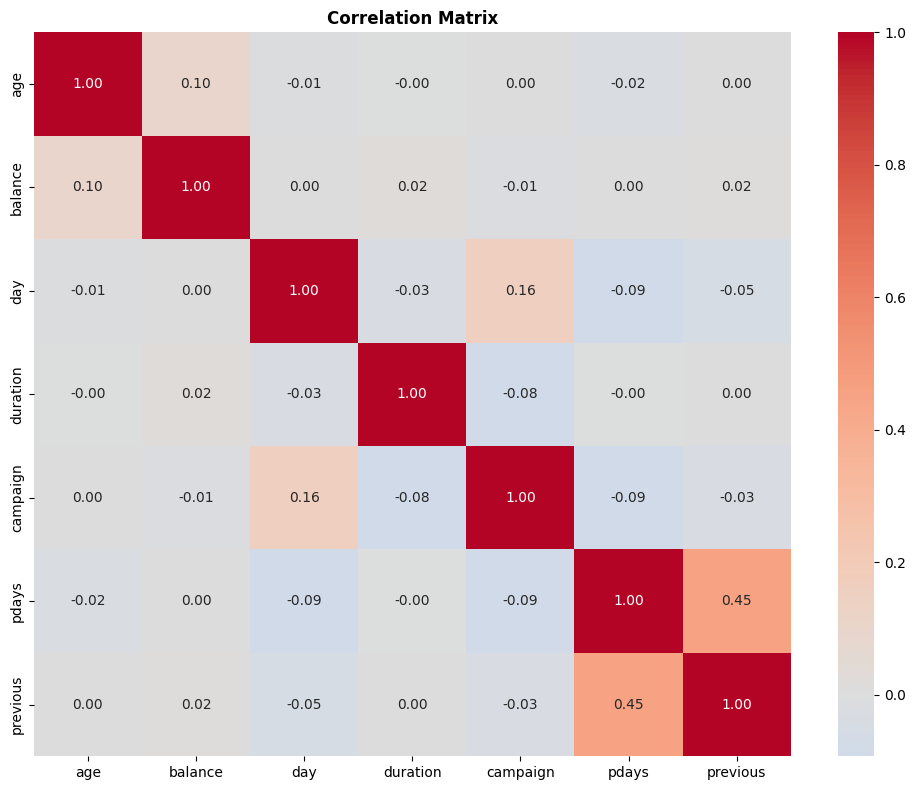

In [132]:
#correlation heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = df[numeric_features].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Correlation Matrix', fontweight='bold')
plt.tight_layout()
plt.show()

In [133]:
#detect outliers using IQR method
print('Outlier Detection (IQR Method):')
print('='*60)

outliers_mask = pd.Series([False] * len(df))

for col in numeric_features:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    col_outliers = ((df[col] < lower_bound) | (df[col] > upper_bound))
    outliers_count = col_outliers.sum()
    
    if outliers_count > 0:
        print(f'{col:15s}: {outliers_count:6,} outliers ({outliers_count/len(df)*100:5.2f}%)')
        outliers_mask = outliers_mask | col_outliers

Outlier Detection (IQR Method):
age            :    487 outliers ( 1.08%)
balance        :  4,729 outliers (10.46%)
duration       :  3,235 outliers ( 7.16%)
campaign       :  3,064 outliers ( 6.78%)
pdays          :  8,257 outliers (18.26%)
previous       :  8,257 outliers (18.26%)


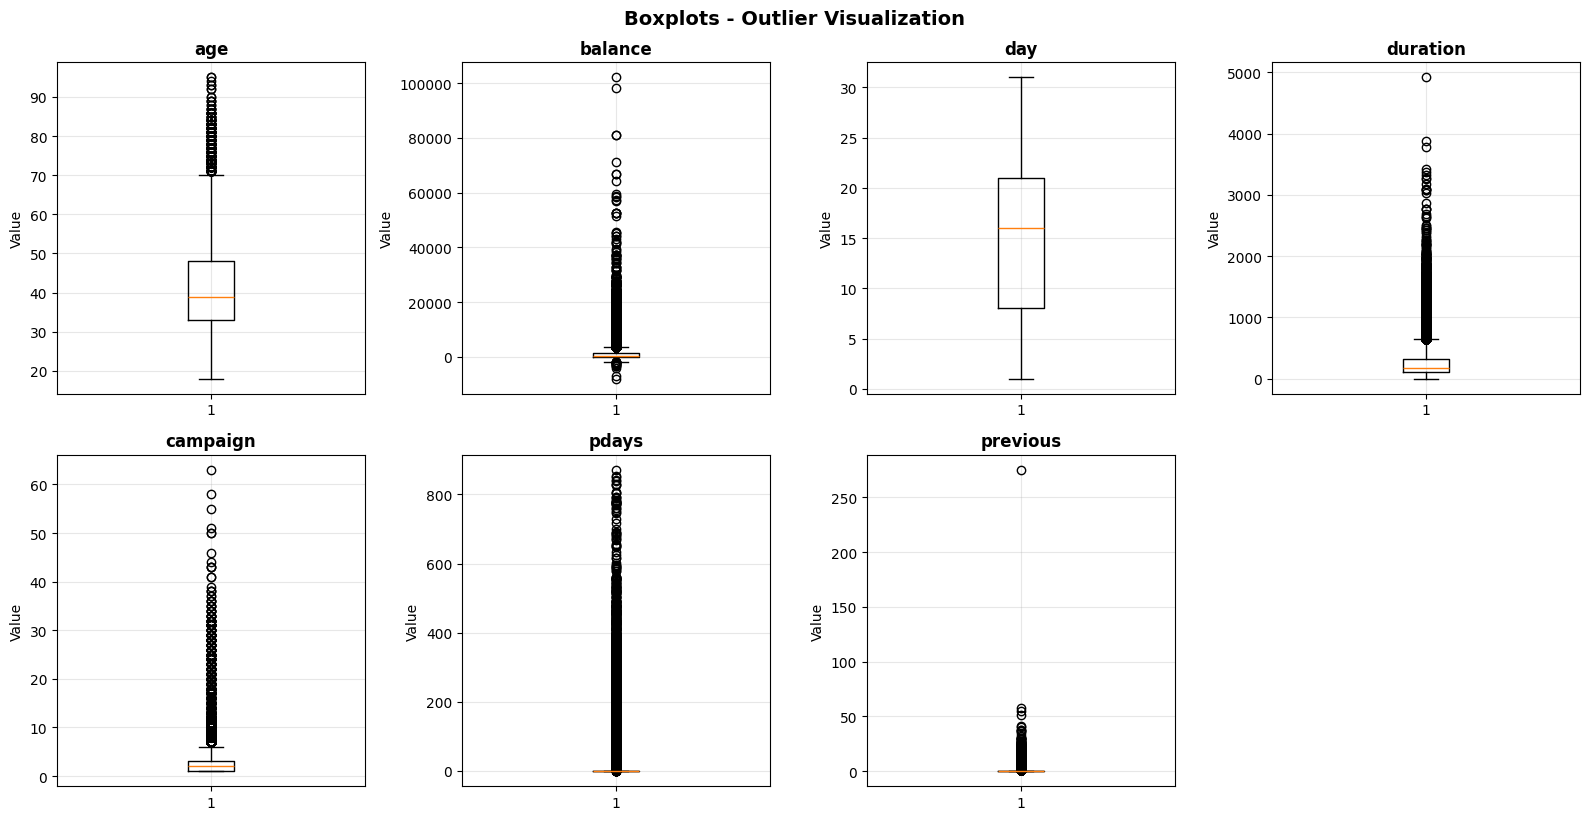

In [134]:
#visualize outliers with boxplots
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

for i, col in enumerate(numeric_features):
    if i < len(axes):
        axes[i].boxplot(df[col].dropna())
        axes[i].set_title(col, fontweight='bold')
        axes[i].set_ylabel('Value')
        axes[i].grid(True, alpha=0.3)

#hide unused subplots
for i in range(len(numeric_features), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.suptitle('Boxplots - Outlier Visualization', fontsize=14, fontweight='bold', y=1.02)
plt.show()

In [135]:
#remove outliers
original_size = len(df)
df_clean = df[~outliers_mask].copy()
removed = original_size - len(df_clean)

print(f'\n Outliers Removed:')
print(f'  Original dataset: {original_size:,} rows')
print(f'  Outliers removed: {removed:,} rows ({removed/original_size*100:.1f}%)')
print(f'  Clean dataset: {len(df_clean):,} rows')

#use clean dataset going forward
df = df_clean.copy()


 Outliers Removed:
  Original dataset: 45,211 rows
  Outliers removed: 17,018 rows (37.6%)
  Clean dataset: 28,193 rows


### **Data Preparation**

Before applying K-Means:

- Drop irrelevant or target columns
- Encode categorical features into numeric format
- Scale numeric features so all are comparable for distance calculations  
- Check that the final dataset has **no missing values** and **all features are numeric**  

In [136]:
#drop 'y' (target) 
#drop 'duration' - not available before call

df_cluster = df.copy()

#drop y
if 'y' in df_cluster.columns:
    df_cluster = df_cluster.drop('y', axis=1)
    print('✓ Target variable "y" removed (unsupervised learning)')

#drop duration
if 'duration' in df_cluster.columns:
    df_cluster = df_cluster.drop('duration', axis=1)
    print('✓ "duration" removed (not available before call)')

print(f'\nShape after dropping columns: {df_cluster.shape}')

✓ Target variable "y" removed (unsupervised learning)
✓ "duration" removed (not available before call)

Shape after dropping columns: (28193, 15)


In [137]:
#update feature lists
categorical_features = df_cluster.select_dtypes(include=['object']).columns.tolist()

#label Encoding for ordinal/binary features
le = LabelEncoder()
label_cols = ['default', 'housing', 'loan', 'education', 'contact', 'poutcome']

print('Label Encoding:')
for col in label_cols:
    if col in df_cluster.columns:
        df_cluster[col] = le.fit_transform(df_cluster[col])
        print(f'  ✓ {col}')

#one-Hot Encoding for nominal features
print('\nOne-Hot Encoding:')
nominal_cols = ['job', 'marital', 'month']
df_cluster = pd.get_dummies(df_cluster, columns=nominal_cols, drop_first=True)
print(f'  ✓ {nominal_cols}')

print(f'\nShape after encoding: {df_cluster.shape}')

Label Encoding:
  ✓ default
  ✓ housing
  ✓ loan
  ✓ education
  ✓ contact
  ✓ poutcome

One-Hot Encoding:
  ✓ ['job', 'marital', 'month']

Shape after encoding: (28193, 36)


In [138]:
#scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)

print('✓ Features scaled using StandardScaler')
print(f'  All features now have mean ≈ 0, std ≈ 1')
print(f'\nFinal dataset shape: {X_scaled.shape}')
print(f'  Samples: {X_scaled.shape[0]:,}')
print(f'  Features: {X_scaled.shape[1]}')

✓ Features scaled using StandardScaler
  All features now have mean ≈ 0, std ≈ 1

Final dataset shape: (28193, 36)
  Samples: 28,193
  Features: 36


In [139]:
#verify dataset is ready
print('Final Dataset Verification:')
print('='*60)
print(f'✓ No missing values: {pd.DataFrame(X_scaled).isnull().sum().sum() == 0}')
print(f'✓ All features numeric: True')
print(f'✓ Outliers removed: True')
print(f'✓ Features scaled: True')
print('\n✓ Dataset ready for K-Means clustering!')

Final Dataset Verification:
✓ No missing values: True
✓ All features numeric: True
✓ Outliers removed: True
✓ Features scaled: True

✓ Dataset ready for K-Means clustering!


### **Apply K-Means Clustering**

- Decide an initial number of clusters (K)  
- Fit the K-Means model to your prepared dataset  
- Assign each data point to a cluster

In [140]:
# Lab 1 approach: Start with K=3
# Lab 1: KMeans(n_clusters=3, n_init=10, random_state=42)

kmeans_3 = KMeans(n_clusters=3, n_init=10, random_state=42)
labels_3 = kmeans_3.fit_predict(X_scaled)

print('✓ K-Means clustering (K=3) completed')
print(f'\nCluster distribution:')
for i in range(3):
    count = (labels_3 == i).sum()
    pct = count / len(labels_3) * 100
    print(f'  Cluster {i}: {count:,} customers ({pct:.1f}%)')

print(f'\nInertia (SSD): {kmeans_3.inertia_:,.2f}')
print(f'Silhouette Score: {silhouette_score(X_scaled, labels_3):.4f}')

✓ K-Means clustering (K=3) completed

Cluster distribution:
  Cluster 0: 9,355 customers (33.2%)
  Cluster 1: 10,963 customers (38.9%)
  Cluster 2: 7,875 customers (27.9%)

Inertia (SSD): 834,736.43
Silhouette Score: 0.0628


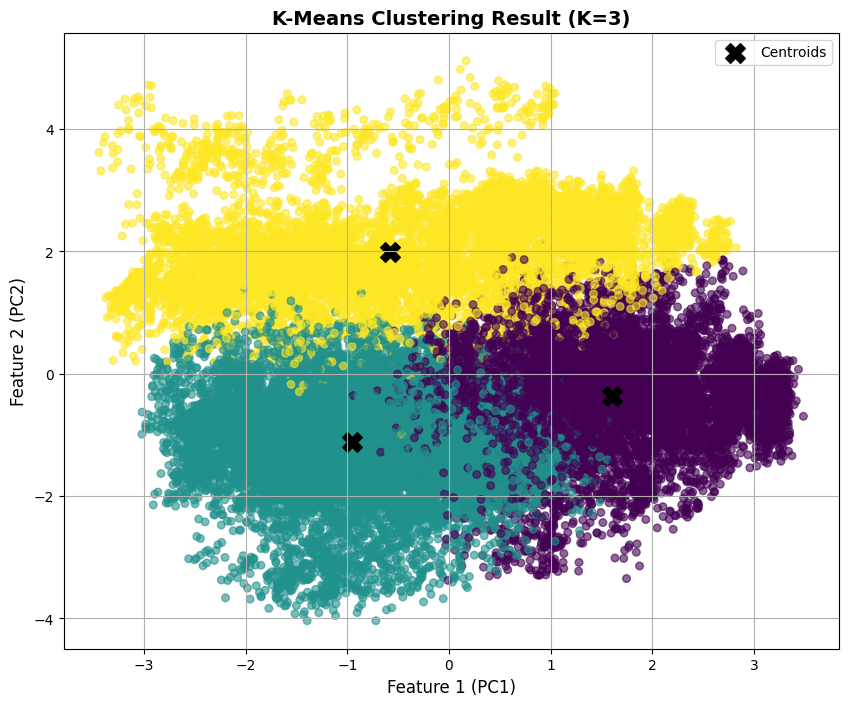

In [141]:
# Lab 1: Plot clusters with centroids
# Use PCA to reduce to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
centroids_pca = pca.transform(kmeans_3.cluster_centers_)

plt.figure(figsize=(10, 8))

# Plot data points (Lab 1 style)
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_3, cmap='viridis', s=30, alpha=0.6)

# Plot centroids (Lab 1 style: black X's)
plt.scatter(centroids_pca[:,0], centroids_pca[:,1], 
           color='black', marker='X', s=200, label='Centroids')

plt.xlabel('Feature 1 (PC1)', fontsize=12)
plt.ylabel('Feature 2 (PC2)', fontsize=12)
plt.title('K-Means Clustering Result (K=3)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True)
plt.show()

### **Choosing the Convenient K**

- Use **Elbow Method**: plot Sum of Squared Distances (SSD) vs K  
- Identify the **elbow point** where SSD reduction slows  
- Calculate **Silhouette scores** to validate K  

In [142]:
# Lab 1 Elbow Method code structure
ssd = []
K_range = range(2, 11)

print('Calculating SSD for different K values...')
for k in K_range:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    km.fit(X_scaled)
    ssd.append(km.inertia_)
    print(f'  K={k}: SSD = {km.inertia_:,.2f}')

print('\n✓ Elbow method calculations completed')

Calculating SSD for different K values...
  K=2: SSD = 873,288.34
  K=3: SSD = 834,736.43
  K=4: SSD = 798,301.65
  K=5: SSD = 766,302.05
  K=6: SSD = 739,178.43
  K=7: SSD = 714,591.23
  K=8: SSD = 688,017.63
  K=9: SSD = 659,962.49
  K=10: SSD = 626,323.45

✓ Elbow method calculations completed


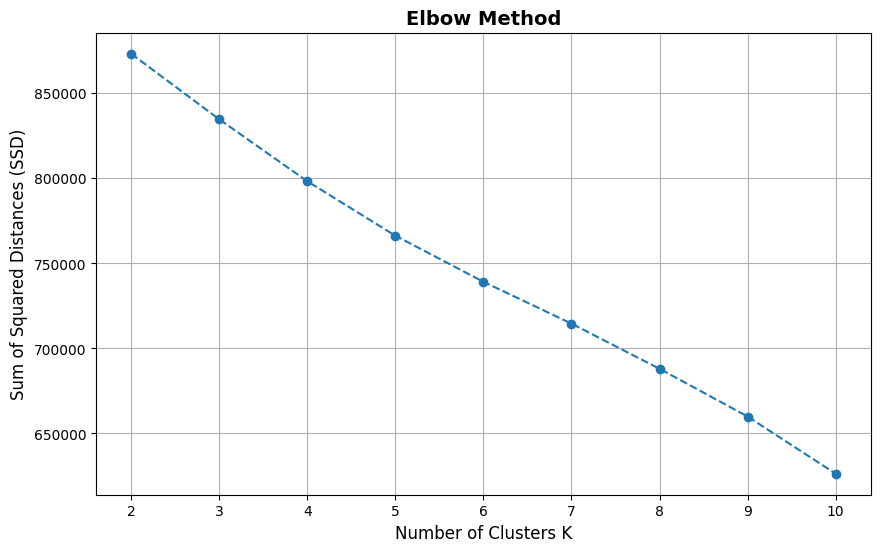


Look for the "elbow" - where SSD reduction slows down


In [143]:
# Lab 1 Elbow plot style
plt.figure(figsize=(10, 6))
plt.plot(K_range, ssd, 'o--')
plt.xlabel('Number of Clusters K', fontsize=12)
plt.ylabel('Sum of Squared Distances (SSD)', fontsize=12)
plt.title('Elbow Method', fontsize=14, fontweight='bold')
plt.grid(True)
plt.xticks(K_range)
plt.show()

print('\nLook for the "elbow" - where SSD reduction slows down')

In [144]:
# Lab 1 Silhouette Score code structure
sil_scores = []

print('Calculating Silhouette Scores...')
for k in range(2, 10):
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = km.fit_predict(X_scaled)
    
    score = silhouette_score(X_scaled, labels)
    sil_scores.append(score)
    print(f'  K={k}: Silhouette Score = {score:.4f}')

best_k = sil_scores.index(max(sil_scores)) + 2
print(f'\n✓ Best K = {best_k} (Silhouette Score: {max(sil_scores):.4f})')

Calculating Silhouette Scores...


  K=2: Silhouette Score = 0.0721
  K=3: Silhouette Score = 0.0628
  K=4: Silhouette Score = 0.0812
  K=5: Silhouette Score = 0.1048
  K=6: Silhouette Score = 0.1252
  K=7: Silhouette Score = 0.1063
  K=8: Silhouette Score = 0.1195
  K=9: Silhouette Score = 0.1379

✓ Best K = 9 (Silhouette Score: 0.1379)


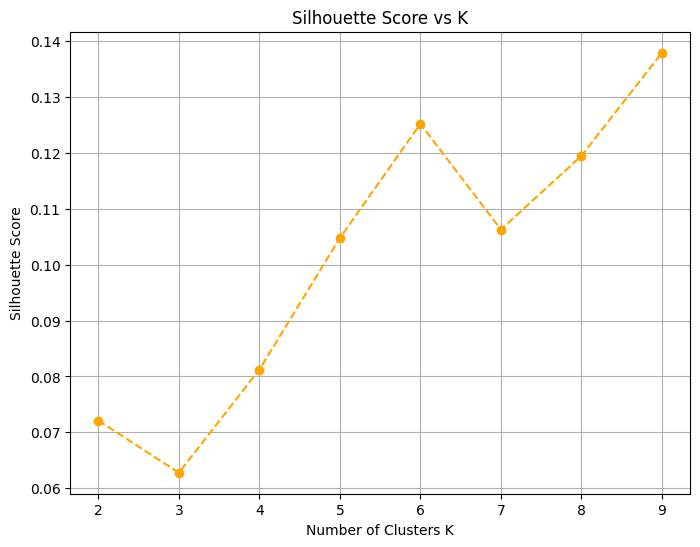

In [145]:
# Plot Silhouette Scores
plt.figure(figsize=(8,6))
plt.plot(range(2,10), sil_scores, 'o--', color='orange')
plt.xlabel("Number of Clusters K")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs K")
plt.grid(True)
plt.show()

In [146]:
# Train final model with optimal K
optimal_k = best_k

print(f'Training final K-Means model with K={optimal_k}...')

# Lab 1 structure: KMeans(n_clusters=K, n_init=10, random_state=42)
kmeans_final = KMeans(n_clusters=optimal_k, n_init=10, random_state=42)
final_labels = kmeans_final.fit_predict(X_scaled)

print('\n✓ Final model trained')
print(f'\nFinal Cluster Distribution:')
for i in range(optimal_k):
    count = (final_labels == i).sum()
    pct = count / len(final_labels) * 100
    print(f'  Cluster {i}: {count:,} customers ({pct:.1f}%)')

print(f'\nFinal Metrics:')
print(f'  Inertia: {kmeans_final.inertia_:,.2f}')
print(f'  Silhouette Score: {silhouette_score(X_scaled, final_labels):.4f}')

Training final K-Means model with K=9...

✓ Final model trained

Final Cluster Distribution:
  Cluster 0: 4,898 customers (17.4%)
  Cluster 1: 3,734 customers (13.2%)
  Cluster 2: 6,982 customers (24.8%)
  Cluster 3: 1,314 customers (4.7%)
  Cluster 4: 3,451 customers (12.2%)
  Cluster 5: 4,250 customers (15.1%)
  Cluster 6: 797 customers (2.8%)
  Cluster 7: 1,988 customers (7.1%)
  Cluster 8: 779 customers (2.8%)

Final Metrics:
  Inertia: 659,962.49
  Silhouette Score: 0.1379


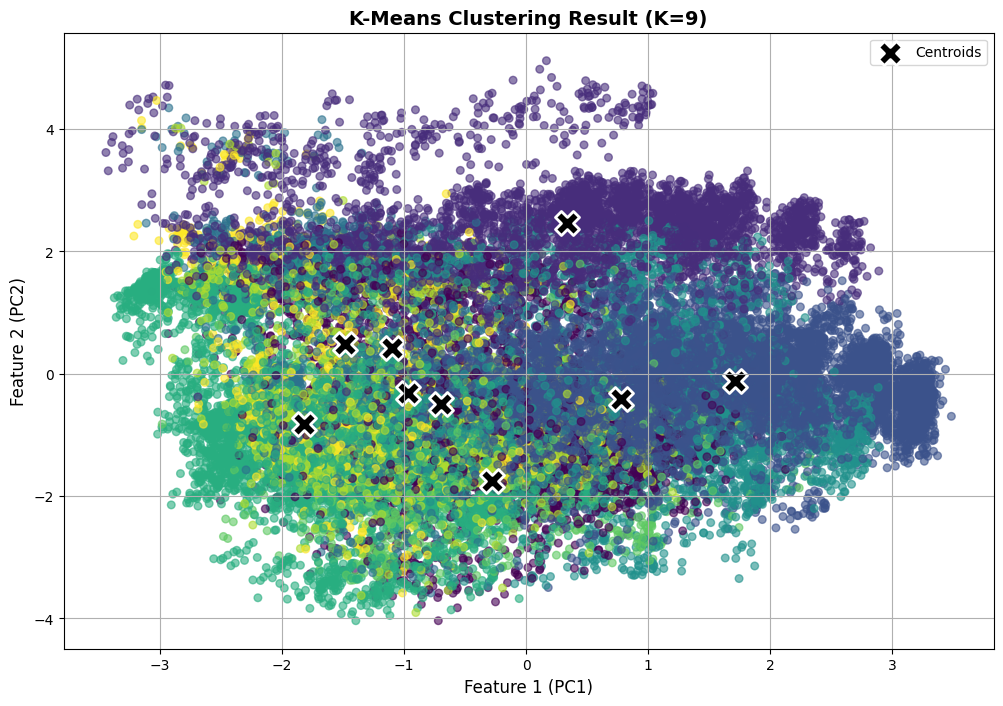

PCA variance explained: 14.8%


In [147]:
# Final visualization with optimal K
pca_final = PCA(n_components=2)
X_pca_final = pca_final.fit_transform(X_scaled)
centroids_pca_final = pca_final.transform(kmeans_final.cluster_centers_)

plt.figure(figsize=(12, 8))

# Plot data points
plt.scatter(X_pca_final[:,0], X_pca_final[:,1], 
           c=final_labels, cmap='viridis', s=30, alpha=0.6)

# Plot centroids
plt.scatter(centroids_pca_final[:,0], centroids_pca_final[:,1], 
           color='black', marker='X', s=300, label='Centroids', 
           edgecolors='white', linewidth=2)

plt.xlabel('Feature 1 (PC1)', fontsize=12)
plt.ylabel('Feature 2 (PC2)', fontsize=12)
plt.title(f'K-Means Clustering Result (K={optimal_k})', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True)
plt.show()

print(f'PCA variance explained: {sum(pca_final.explained_variance_ratio_)*100:.1f}%')